In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits

# Part 1

To start, let's read in the data and plot it to get a sense of what we are working with. 

Map has shape: (4000, 6000)


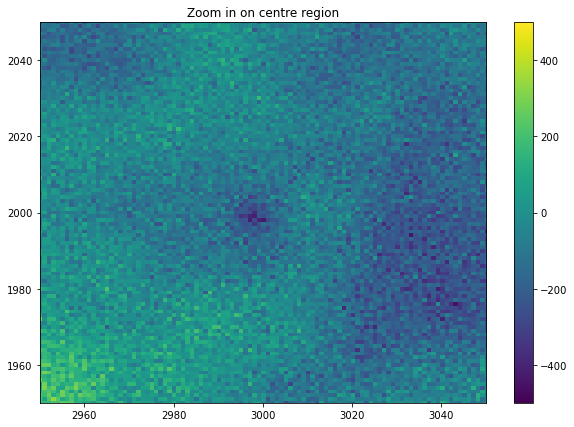

In [2]:
hdul = fits.open('advact_tt_patch.fits')
sky_map = np.asarray(hdul[0].data, dtype=np.float64)
hdul.close()

nrow = sky_map.shape[0]
ncol = sky_map.shape[1]

print('Map has shape:',sky_map.shape)
plt.figure(figsize=(10,7))
plt.imshow(sky_map, aspect='auto', vmin=-500, vmax=500)
plt.title('Zoom in on centre region')
plt.colorbar()
plt.xlim(2950, 3050)
plt.ylim(1950,2050)
plt.show()

Now that we have an idea of where the region is on the map, let's go ahead and fit a Gaussian to the cluster in the centre of the map. We'll follow a similar approach to how we did it in class. Note that I've taken the code Jon wrote in class and modified it to my needs wherever needed. 

In [3]:
def mygauss(pars,width):
    vec=np.asarray(np.arange(-width,width),dtype='float')
    amp=pars[0]
    dx=pars[1]
    dy=pars[2]
    sig=pars[3]
    c = pars[4]

    xvec=vec-dx
    yvec=vec-dy
    xmat=np.outer(xvec,np.ones(len(xvec)))
    ymat=np.outer(np.ones(len(yvec)),yvec)
    rmat=xmat**2+ymat**2
    model=np.exp(-0.5*(rmat/sig**2))*amp + c

    return model

def get_model_derivs(fun,pars,dpar,width):
    model=fun(pars,width)
    npar=len(pars)
    derivs=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pars[i]+dpar[i]
        m_plus=fun(pp,width)
        pp[i]=pars[i]-dpar[i]
        m_minus=fun(pp,width)
        derivs[i]=(m_plus-m_minus)/(2*dpar[i])
    return model,derivs

def get_model_derivs_ravel(fun,pars,dpar,width):
    model,derivs=get_model_derivs(fun,pars,dpar,width)
    model=np.ravel(model)
    npar=len(pars)
    derivs_out=np.empty([len(model),len(pars)])
    for i in range(npar):
        derivs_out[:,i]=np.ravel(derivs[i])
    return model,derivs_out

def newton(pars,data,fun,width,dpar,Ninv,niter=10):
    for i in range(niter):
        model,derivs=get_model_derivs_ravel(fun,pars,dpar,width)
        resid=data-model
        lhs=derivs.T@Ninv@derivs
        rhs=derivs.T@(Ninv@resid)
        shift=np.linalg.inv(lhs)@rhs
        pars=pars+shift
    return pars

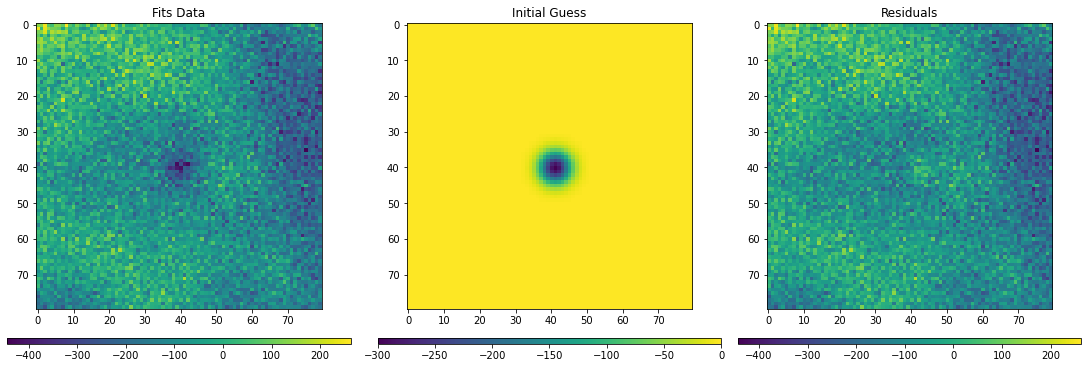

In [4]:
# Define initial parameters to carry out Newton best fit 
x0 = 1999
y0 = 2998
width = 40
map_use = sky_map[x0-width:x0+width,y0-width:y0+width]

pars_guess = np.asarray([-300, 0, 1, 3, 0], dtype=np.float64)
dpar = np.asarray([1.0, 0.01, 0.01, 0.01, 1])/10

model_guess = mygauss(pars_guess, width)
fig, axs = plt.subplots(1,3, figsize=(15,5), constrained_layout=True)
im0 = axs[0].imshow(map_use)
im2 = axs[2].imshow(map_use - model_guess)
im1 = axs[1].imshow(model_guess)
fig.colorbar(im0, ax=axs[0], location='bottom')
fig.colorbar(im1, ax=axs[1], location='bottom')
fig.colorbar(im2, ax=axs[2], location='bottom')
axs[0].set_title('Fits Data')
axs[1].set_title('Initial Guess')
axs[2].set_title('Residuals')
plt.show()



# Estimate noise matrix, assuming map noise is uniform and uncorrelated between map pixels
sig = np.std(map_use - model_guess)
Ninv = np.eye(map_use.shape[0]**2)/sig**2

Final chisq: 6336.48204704597
Fit parameters: [-185.63482552   -0.43441817   -0.72537029    5.15452029  -74.77850157]
Number of degrees of freedom: 6395


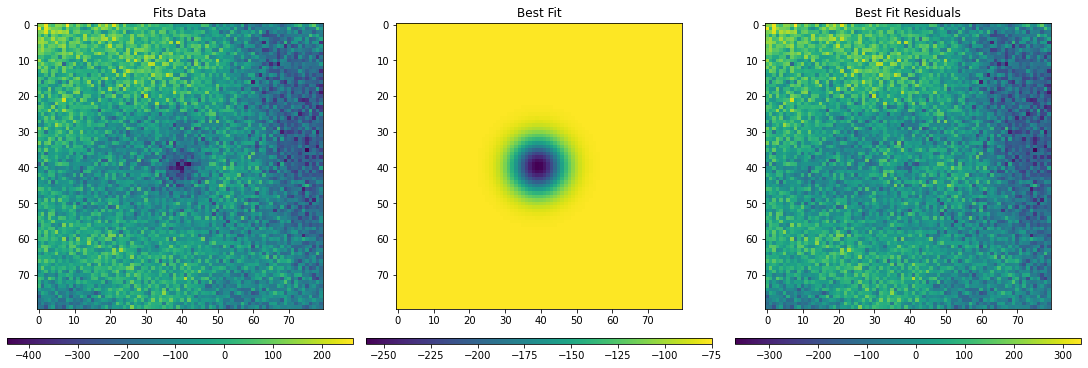

In [5]:
# Run fit algorithm 
fitp = newton(pars_guess, np.ravel(map_use), mygauss, width, dpar, Ninv, niter=20)
mymod = mygauss(fitp, width)

# Estimate noise using leftover noise after removing signal 
fit_chisq=np.sum((map_use-mymod)**2/sig**2)
print('Final chisq:', fit_chisq)
print('Fit parameters:', fitp)
print('Number of degrees of freedom:', mymod.size - pars_guess.size)

fig, axs = plt.subplots(1,3, figsize=(15,5), constrained_layout=True)
im0 = axs[0].imshow(map_use)
im2 = axs[2].imshow(map_use - mymod)
im1 = axs[1].imshow(mymod)
fig.colorbar(im0, ax=axs[0], location='bottom')
fig.colorbar(im1, ax=axs[1], location='bottom')
fig.colorbar(im2, ax=axs[2], location='bottom')
axs[0].set_title('Fits Data')
axs[1].set_title('Best Fit')
axs[2].set_title('Best Fit Residuals')
plt.show()

The best fit parameters are printed above. Note that I modified the model slightly by including an additional constant offset to distinguish the source from the background noise. Without it, Newton's method would constantly overestimate the width. Note that given the mean of $\chi^2$ is equal to the number of degrees of freedom (in this case 3595) with standard deviation ~60, our final chisq falls outside of the 1$\sigma$ region, but isn't terribly far off. However, a better estimate of the noise would definitely bring us closer. 

# Part 2

In [7]:
import importlib
import act_mf_tools
importlib.reload(act_mf_tools)
from act_mf_tools import get_gauss_kernel

In [74]:
def estimate_ps(vec, sig):    
    # Kernel is in Fourier space by default
    kernel = get_gauss_kernel(vec, sig, norm = True)
    
    kernel_ft = np.fft.fft2(kernel)
    
    # Get power spec
    ps = np.abs(np.fft.fft2(vec))**2
    
    ps_ft = np.fft.fft2(ps)
    
    # Convolve
    smoothed_ps = np.fft.ifft2(kernel_ft*ps_ft)
    
    npts = vec.size
    
    return np.real(smoothed_ps)

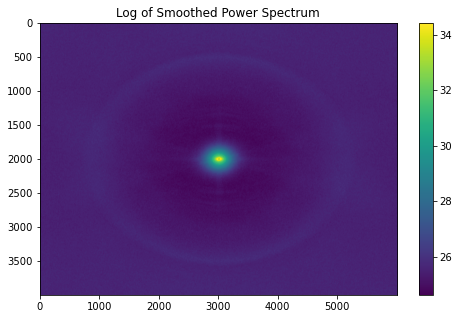

In [75]:
smoothed_ps = estimate_ps(sky_map, fitp[-2])

# Plot 2D power spec 
plt.figure(figsize=(8,5))
plt.title('Log of Smoothed Power Spectrum')
plt.imshow(np.fft.fftshift((np.log(smoothed_ps))), aspect='auto')
plt.colorbar()
plt.show()

# Part 3

In [86]:
def filter_map(vec, smoothed_ps):
    
    npts = vec.size
    map_fft = np.fft.fft2(vec)
    Ninv = 1/smoothed_ps

    return np.real(np.fft.ifft2(map_fft*Ninv)) * npts


filtered_map = filter_map(sky_map, smoothed_ps)

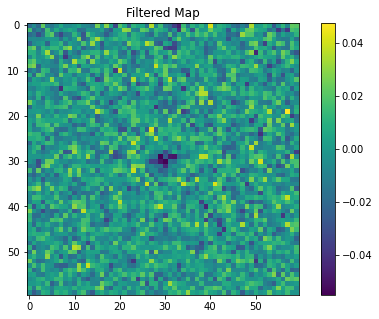

In [87]:
plt.figure(figsize=(8,5))
plt.imshow(filtered_map[x0-30:x0+30,y0-30:y0+30])
plt.colorbar()
plt.title('Filtered Map')
plt.show()


# Part 4

In [88]:
# Generate white noise 
_width = 100
white_noise = np.random.randn(2*_width,2*_width)
ps_white = estimate_ps(white_noise, sig = 500)
filtered_white = filter_map(white_noise, ps_white)
print('Variance:', np.var(filtered_white))

Variance: 0.9998514594854271


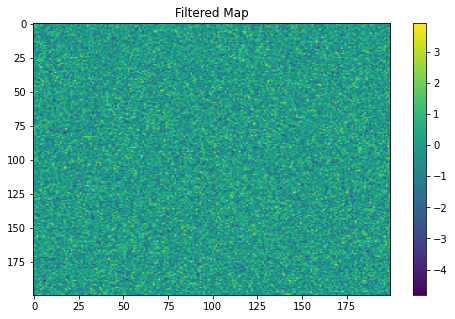

In [89]:
plt.figure(figsize=(8,5))
plt.imshow(filtered_white, aspect='auto')
plt.colorbar()
plt.title('Filtered Map')
plt.show()